In [1]:
##################################################
####### Method: Linear Inverse Modelling  ########
##################################################
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from netCDF4 import Dataset
from functionsLIM import *
from datetime import datetime
from pylim import LIM
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
# np.random.seed(42)

num_cores = multiprocessing.cpu_count()
print('Number of cores:',num_cores)

# Define other parameters of the problem
n_pc = 150         # number of PCs
n_record = 50000   # total records
n_maxtrain = 40000 # maximum possible length of training data
n_test = n_record - n_maxtrain # length of the test data
test0_idx = 40000              # test data start index
dt = 10            # temporal resolution

#### Load the pcs ####
f = 'psi1_DG_0_500K_100days_filtered_150PCs.dat'
pcs = dlmread(f, n_record)
pcs = center(pcs)
# get the test dataset
test_data = pcs[test0_idx:test0_idx+n_test, :]
 
#### Load the EOFs ####
nx = 513; ny=513
eoffile = os.getcwd() + '/../psi1_DG_0_500K_100days_filtered_150EOFs.nc'
fid = Dataset(eoffile,'r')
eofs = fid.variables['EOFs'][:]
eofs = eofs.reshape((n_pc, nx*ny))

In [2]:
# get the training dataset
n_train = n_maxtrain # Length used for training
train_data, scaler = trainingData(pcs, n_train, 'standard')

In [3]:
# Perform the linear inverse modelling on the dataset
lim = LIM.LIM(tau0_data=train_data, fit_noise=True)

In [4]:
# Peform forecasts
n_maxlead = 10                    # maximum lead time
n_ic = int((n_test - n_maxlead))  # number of initial conditions 
nensem = 100                      # number of stochastic ensembles
t0_data = test_data[:n_ic,:]      # initial conditions
tf_data = np.zeros(np.shape(t0_data)) 
all_states = np.zeros((n_maxlead+1,n_ic,n_pc))
y_pred = np.zeros((nensem,n_ic,n_maxlead,n_pc))
fcast = np.zeros((n_maxlead,n_ic,n_pc))
temp = np.zeros(np.shape(t0_data))
temp1 = np.zeros(np.shape(temp))

In [5]:
#### LIM forecast with noise #### 
for i in range(nensem):
    # here tf_data only contains the final state; states at all other 
    # time steps are in all_states with the first one as the initializing state
    tf_data = lim.noise_integration(t0_data,n_maxlead,timesteps=1,out_arr=all_states)

    # We need to post-process all_states, because, at any time step t, LIM stores the 
    # average of the forecast at time step t and t-1
    temp = t0_data
    for j in range(n_maxlead):
        temp1 = 2*all_states[j+1,:,:] - temp
        fcast[j,:,:] = temp1
        temp = temp1
    
    y_pred[i,:,:,:] = np.moveaxis(fcast,0,1)

/rds/general/user/na517/home/anaconda3/envs/tensorflowML/lib/python3.6/site-packages/pylim-0.9.1-py3.6.egg/pylim/LIM.py:420: ComplexWarning: Casting complex values to real discards the imaginary part


In [6]:
enMean_y_pred = np.mean(y_pred, axis=0)

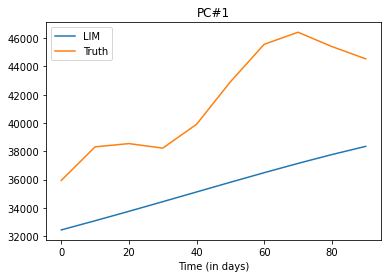

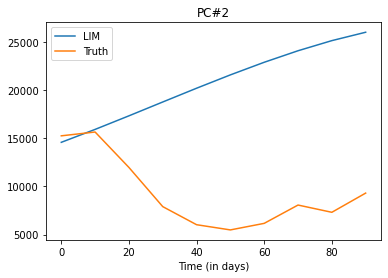

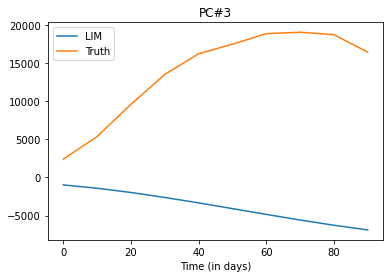

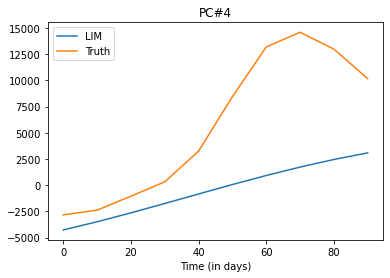

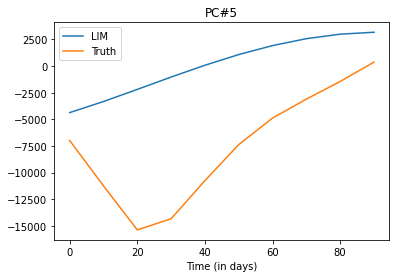

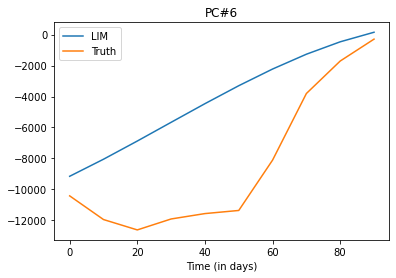

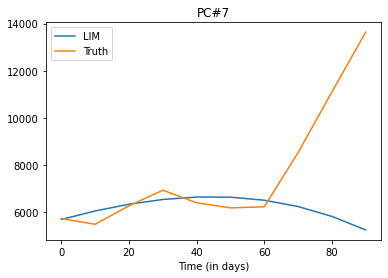

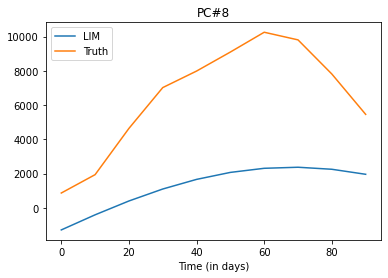

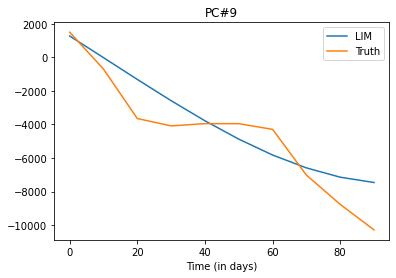

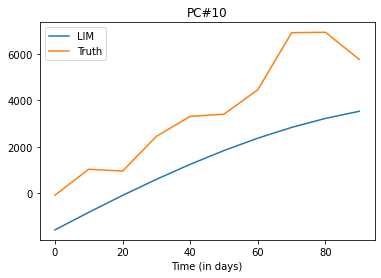

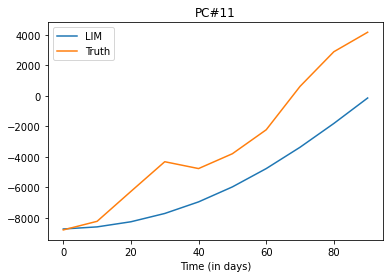

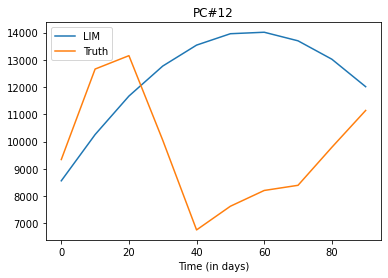

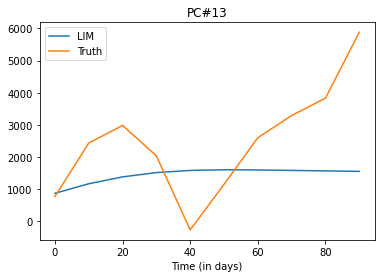

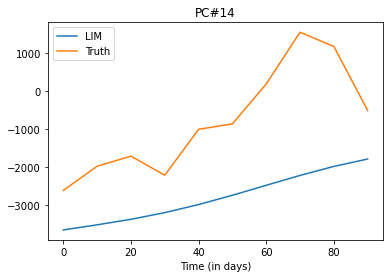

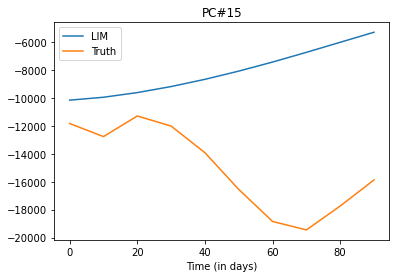

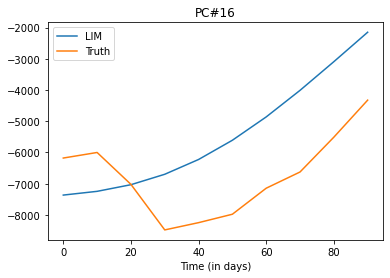

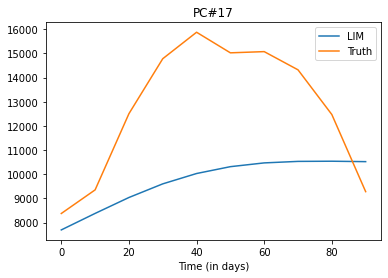

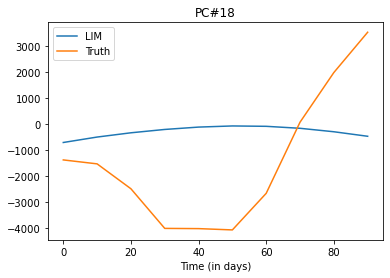

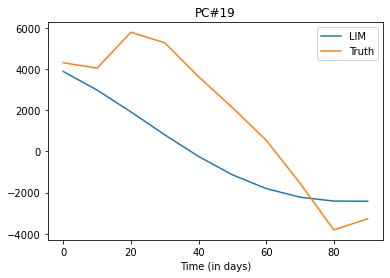

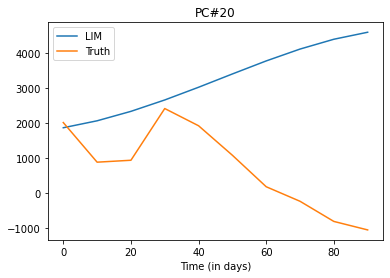

In [7]:
# Plot the predicted results against the truth for any initial condition
# Remember that the first time step of the forecasted matrix is not the initial
# condition, as it is in LR, but it's the lag=1 forecast based on the initial condition.
ic = 0       # IC index; should be 0,1,2,3..., nic-1 
for k in range(20):
    plt.figure()
    x = np.arange(0,n_maxlead*dt,10)
    plt.plot(x,enMean_y_pred[ic,:,k],label='LIM')
    #plt.plot(x,y_pred[ic,:,k],label='LIM')
    true_ = test_data[ic+1:ic+n_maxlead+1,k]
    plt.plot(x,true_,label='Truth')
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k+1))
    plt.legend()
    plt.show()

In [13]:
####################################################################
############ Metric 1 : RMSE on the physical space #################
###### Use each data point of the test dataset as an IC ############
## Obtain 100 stochastic realizations (if applicable) for each IC ##
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))

start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,enMean_y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))

meanRMSE = np.mean(rmse, axis=0)

100%|██████████| 9990/9990 [08:57<00:00, 18.58it/s]


In [14]:
np.save('RMSE_Psi1_100days_predictions_LIMwithNoise_npc=150_nic=9990_nensem=100_ntrain=400K_ntest=100K',meanRMSE)

In [15]:
##########################################################
########### LIM forecast without noise : SLR #############
##########################################################
y_pred_SLR = lim.forecast(t0_data,np.arange(0,n_maxlead,1),use_h5=False) # shape:(maxlead, nic, npc)
y_pred_SLR = np.moveaxis(y_pred_SLR,1,0)

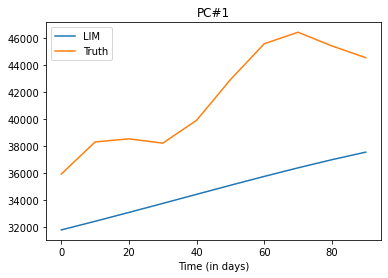

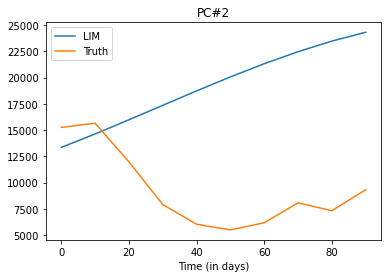

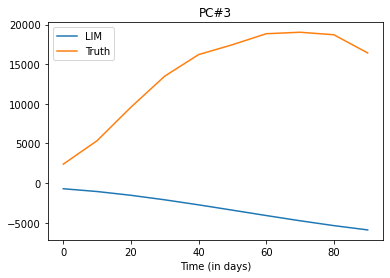

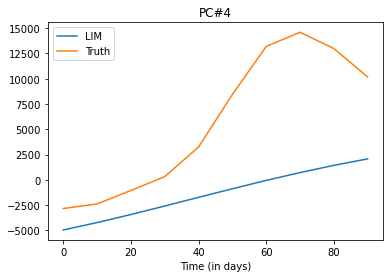

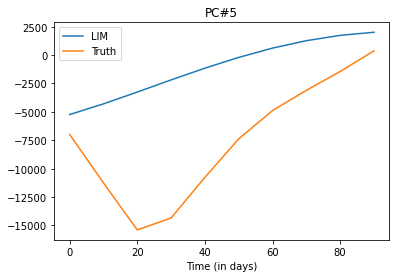

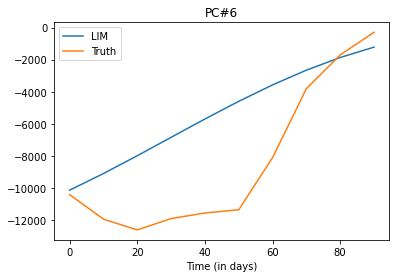

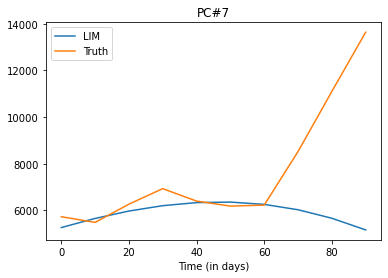

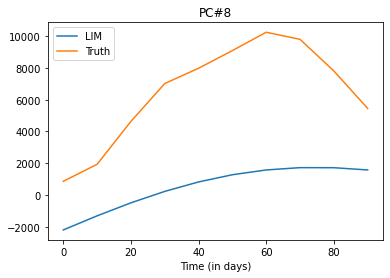

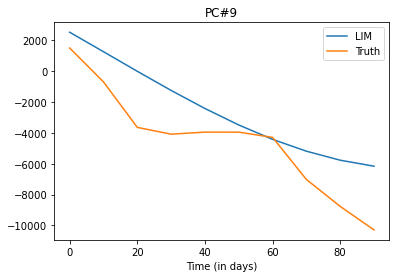

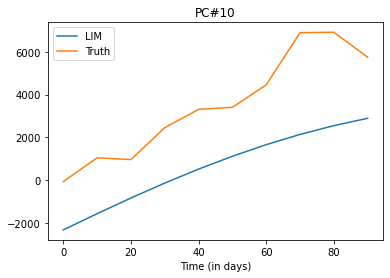

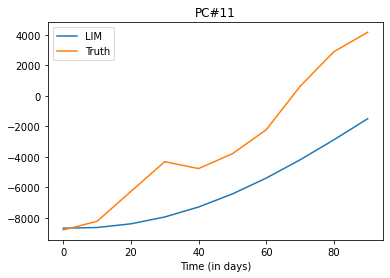

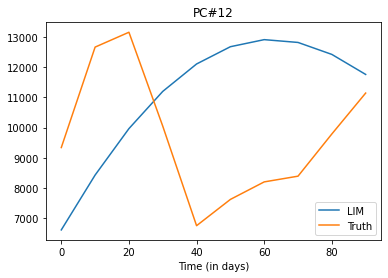

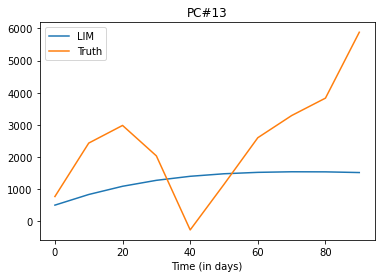

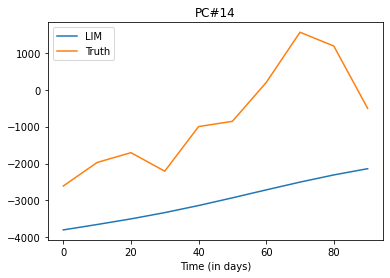

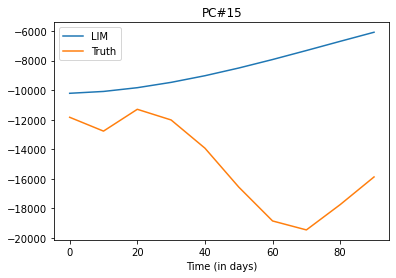

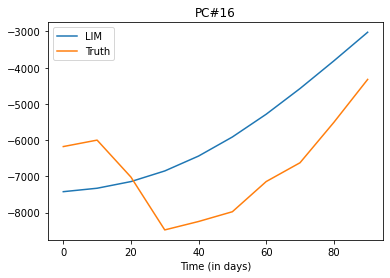

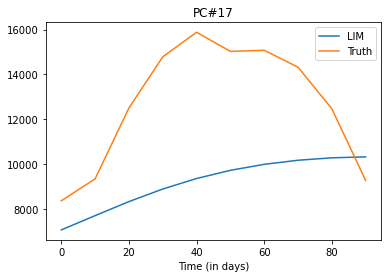

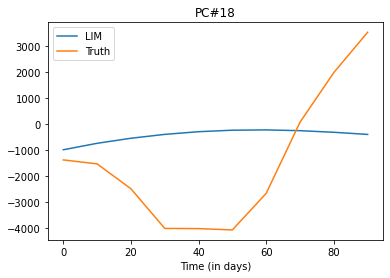

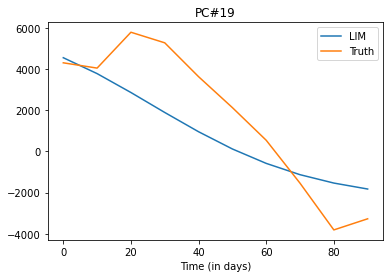

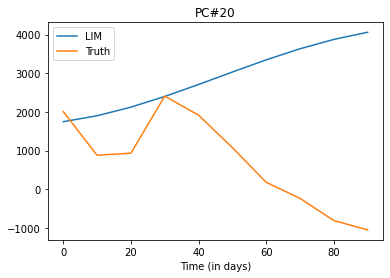

In [16]:
# Plot the predicted results against the truth for any initial condition
# Remember that the first time step of the forecasted matrix is not the initial
# condition, as it is in LR, but it's the lag=1 forecast based on the initial condition.
ic = 0       # IC index; should be 0,1,2,3..., nic-1 
for k in range(20):
    plt.figure()
    x = np.arange(0,n_maxlead*dt,10)
    plt.plot(x,y_pred_SLR[ic,:,k],label='LIM')
    true_ = test_data[ic+1:ic+n_maxlead+1,k]
    plt.plot(x,true_,label='Truth')
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k+1))
    plt.legend()
    plt.show()

In [17]:
####################################################################
################## RMSE on the physical space ######################
###### Use each data point of the test dataset as an IC ############
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))

start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,y_pred_SLR,eofs,n_maxlead) for i in tqdm(range(n_ic)))

meanRMSE_SLR = np.mean(rmse, axis=0)

100%|██████████| 9990/9990 [09:04<00:00, 18.34it/s]


In [18]:
np.save('RMSE_Psi1_100days_predictions_LIMwithoutNoise_npc=150_nic=9990_ntrain=400K_ntest=100K',meanRMSE_SLR)

In [ ]:
############# ALERT ALERT ALERT ALERT ########################
##### Computation of the below metrics are not required ######
##############################################################

In [ ]:
################################################################
##### Metric : Instantaneous correlation coefficient (ICC) #####
######### Obtain multiple realizations of 10,000 days  #########
################################################################
enicc = np.zeros((n_ic, nx*ny))

start = datetime.now()
for kk in range(1):
    psi1_true = test_data[kk+1:kk+n_maxlead+1,:].dot(eofs)
    psi1_pred = y_pred[kk,:,:].dot(eofs)
    enicc[kk,:] = ICC(psi1_true, psi1_pred)
    
print('Time elapsed:',datetime.now()-start)
meanicc = np.mean(enicc, axis=0)

plt.imshow(meanicc.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.colorbar()
plt.show()

In [8]:
################################################################
################### Metric 2 : Climatology #####################
######### Obtain multiple realizations of 10,000 days  #########
################################################################
n_ic = 1    # Number of initial conditions   
n_maxlead = 1000  # Prediction of 1000 records for each realization

start = datetime.now()

t0_data = test_data[:n_ic,:] # initial conditions
# Produce forecasts on long time scales
y_pred = lim.forecast(t0_data, fcast_leads=np.arange(1,n_maxlead+1), use_h5=False) # shape:(maxlead, nic, npc)
y_pred = np.moveaxis(y_pred,1,0)

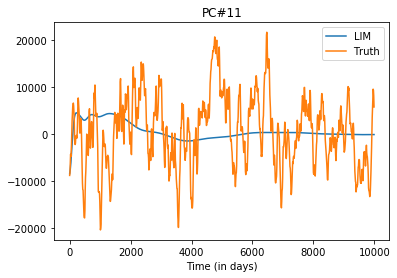

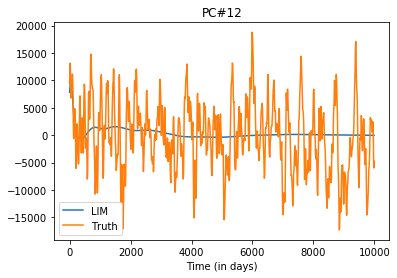

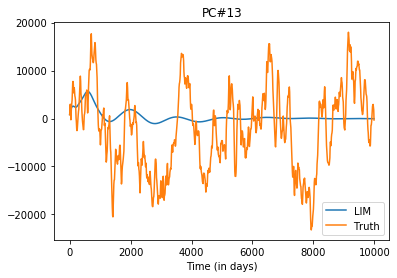

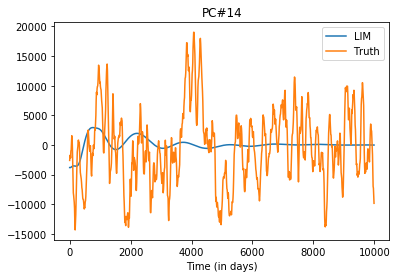

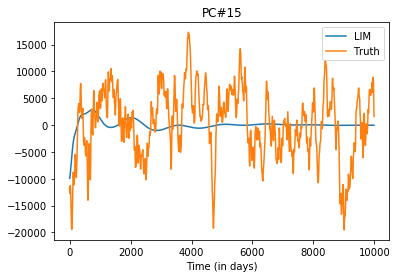

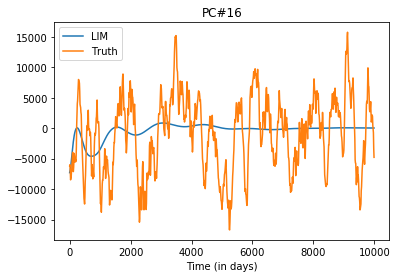

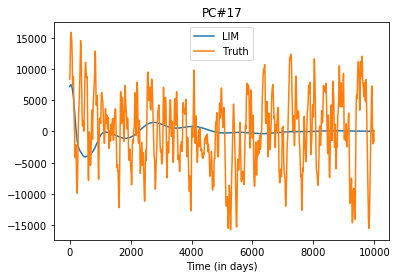

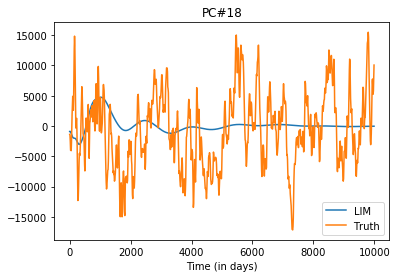

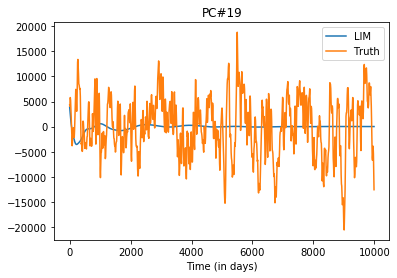

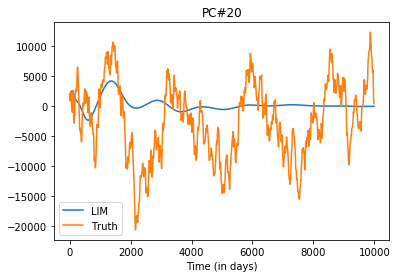

In [9]:
ic = 0       # IC index; should be 0,1,2,3..., nic-1 
for k in range(10,20):
    plt.figure()
    x = np.arange(0,n_maxlead*dt,10)
    plt.plot(x,y_pred[ic,:,k],label='LIM')
    true_ = test_data[ic+1:ic+n_maxlead+1,k]
    plt.plot(x,true_,label='Truth')
    plt.title('PC#' + str(k+1))
    plt.xlabel('Time (in days)')
    plt.legend()
    plt.show()

In [10]:
# Project the modelled PCs onto the EOFs and calculate climatology
psi1_climatology_pred = np.zeros((n_ic, nx*ny)) # Time mean statistics
psi1_climatology_true = np.zeros((n_ic, nx*ny))

for kk in range(n_ic):
    psi1_true = test_data[kk+1:kk+n_maxlead+1,:].dot(eofs)
    psi1_climatology_true[kk,:] = np.mean(psi1_true, axis=0)
    
    psi1_pred = y_pred[kk,:,:].dot(eofs)
    psi1_climatology_pred[kk,:] = np.mean(psi1_pred, axis=0)

mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)

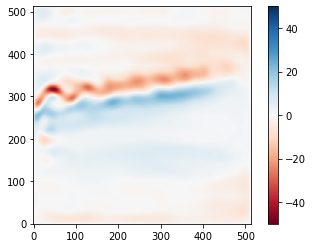

In [11]:
plt.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-50, 50)
plt.colorbar()
plt.savefig('Mean_Climatology_Psi1_10Kdays_predictions_LIM_npc=150_nic=9980.png',dpi=100)
plt.show()

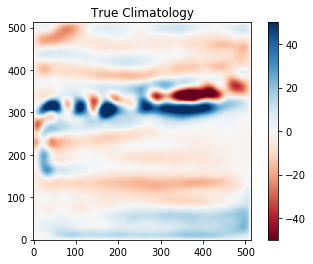

In [12]:
# Check the true climatology for the realizations performed
mean_psi1_climatology_true = np.mean(psi1_climatology_true, axis=0)
plt.imshow(mean_psi1_climatology_true.reshape(nx,ny), \
           origin='lower', cmap='RdBu')
plt.clim(-50,50)
plt.colorbar()
plt.title('True Climatology')
plt.savefig('Mean_Climatology_Psi1_10Kdays_true_npc=150_ic=1.png',dpi=100)
plt.show()

In [13]:
################################################################
##### Metric : Instantaneous correlation coefficient (ICC) #####
######### Obtain multiple realizations of 10,000 days  #########
################################################################
enicc = np.zeros((n_ic, nx*ny))

start = datetime.now()
for kk in range(1):
    psi1_true = test_data[kk+1:kk+n_maxlead+1,:].dot(eofs)
    psi1_pred = y_pred[kk,:,:].dot(eofs)
    enicc[kk,:] = ICC(psi1_true, psi1_pred)
    
print('Time elapsed:',datetime.now()-start)
meanicc = np.mean(enicc, axis=0)

Time elapsed: 0:01:21.675082


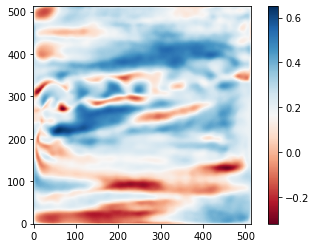

In [14]:
plt.imshow(meanicc.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.colorbar()
plt.show()